# Jerk Limited Motion Control
Adham Elarabawy  
June 2021

## **Source**
All referenced implementations can be found in [my motion repository](https://github.com/adham-elarabawy/motion). 

All jerk-limited implementations are based on [this textbook](http://home.elka.pw.edu.pl/~ptrojane/books/Trajectory_Planning_for_Automatic_Machines_and_Robots.pdf).

## **Introduction**

Currently, all simple motion planning that occurs on the Fuse machines is orchestrated by a trapezoidal/triangular motion planner, which effectively describes the resulting velocity profile. 

**Note:** *From here on out, I will be referring to triangular and trapezoidal velocity profiles as trapezoidal for concision. The main difference is that a triangular profile is used when the maximum velocity is not reached based on the given parameters, so the trajectory must decelerate before hitting a velocity plateau.*

This trapezoidal velocity profile is generated via setting maximum acceleration/deceleration during certain periods, and then integrating the resultant acceleration to generate the corresponding velocity/position profiles. These profiles can then be discretized and sampled to generate low-level stepper motor move commands.

Here is an example of a trapezoidal velocity profile:

![Trapezoidal Velocity Profile](https://github.com/adham-elarabawy/motion/blob/main/media/trapezoidal.png?raw=true)

The above trajectory was generated by [this code](https://github.com/adham-elarabawy/motion/blob/main/examples/run_trapezoidal.py).

### **What's the problem?**

As you can see in the below diagram, there are points of instantaneous change in acceleration (circled in red), which correlate to extremely large jerk values -- which result in unwanted system properties (vibrations & more time needed to settle).

![Trapezoidal Velocity Profile Problems](https://github.com/adham-elarabawy/motion/blob/main/media/trapezoidal_diagram.png?raw=true)


To solve this problem, we set a jerk limit and effectively perform the same algorithm as before, integrating each previous profile to generate acceleration from jerk, velocity from acceleration, and position from velocity. This explanation is greatly simplified, since it completely glosses over how we actually know how long we need to accelerate, decelerate, etc. This will be explained in-depth later in this note, but it is important to first illustrate the fundamental theory.

Here is an example of a jerk-limited velocity profile:

![Jerk Limited Velocity Profile](https://github.com/adham-elarabawy/motion/blob/main/media/jerklimited.png?raw=true)

The above trajectory was generated by [this code](https://github.com/adham-elarabawy/motion/blob/main/examples/run_jerk_limited.py).

### **A quick concession + rebuttal**
Before we can fully dive into the math behind the jerk limited trajectory generation, I want to emphasize an important point with regards to time optimality and compromises.

Clearly, by reducing the portions in which we are allowing our system to travel at maximum acceleration, we are generating a trajectory that is comparatively slower than a simple trapezoidal velocity profile. Intuitively, this makes sense -- and it should since it is true.

However, it is important to bring attention to the role of system dynamics within the context of trajectory planning. Sure, generating a jerk-limited trajectory with the equivalent parameters as a trapezoidal trajectory will give you a trajectory that takes longer to execute. The key insight is in noting that a jerk-limited trajectory theoretically allows you to **increase** your maximum acceleration and velocity, since those are usually driven by experiments on system stability anyways. So, a jerk-limited approach may actually result in faster trajectories, since it will allow you to be more aggressive with the values you pick for max acceleration and velocity.  

Additionally, the performance benefits of jerk-limited trajectories are well documented: theoretically less mechanical stress on your system, seemingly softer moves (without any "jerky" moves), etc.

## **Implementation Flowchart + Phase Plot**
|Phase Name|Description|
|---|---|
|$T_{j1}$|time-interval in which the jerk is constant (jmax or jmin) during the acceleration phase.|
|$T_{j2}$|time-interval in which the jerk is constant (jmax or jmin) during the deceleration phase.|
|$T_{a}$|acceleration period.|
|$T_{v}$|constant velocity period.|
|$T_{d}$|deceleration period.|
|$T$|total duration of the trajectory $( = T_a + T_v + T_d)$.|

![Phase Plot](https://github.com/adham-elarabawy/motion/blob/main/media/phase_plot.png?raw=true)

![Flowchart](https://github.com/adham-elarabawy/motion/blob/main/media/flowchart.png?raw=true)



## **Technical Implementation**

The technical implementation that I am describing here is thoroughly and formally explained in [this textbook](http://home.elka.pw.edu.pl/~ptrojane/books/Trajectory_Planning_for_Automatic_Machines_and_Robots.pdf#page=88) starting on page 88-110. However, I will spare you the verbosity and will instead walk you through my python implementation of the described jerk-limited trajectory generation algorithm. You can find my raw python source code for the following jerk-limited trajectory generation [here](https://github.com/adham-elarabawy/motion/blob/main/engine/jerk_limited.py).

#### **Imports**
First, we import the required dependencies

In [5]:
# computation dependencies
import numpy as np

# visualization dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### **Initial parameters**
Here, we set the initial conditions. If we were making this a function, these are the parameters we would pass in for each generated trajectory.

In [22]:
_q0 = 0     # initial position (mm)
_q1 = 10    # final position (mm)
_v0 = 1     # initial velocity (mm/s)
_v1 = 0     # final velocity (mm/s)
_v_max = 5 # maximum velocity (mm/s)
_a_max = 10 # maximum acceleration (mm/s^2)
_j_max = 15 # maximum jerk (mm/s^3)
alpha = 0.9 # iterative scaling constant (will be described in detail later.)

#### **Parameter cleanup**
Here, we perform a cleanup on our input parameters such that we allow reversed inputs (where the initial position is larger than the final position).

This is mitigated by the omega constant which is simply defined as: $$ \omega =  sign({\_q}_1 - {\_q}_0) $$

In [23]:
omega = np.sign(_q1 - _q0)

_v_min = -_v_max
_a_min = -_a_max
_j_min = -_j_max

q0 = omega * _q0
q1 = omega * _q1
v0 = omega * _v0
v1 = omega * _v1
v_max = ((omega + 1) / 2) * _v_max + ((omega - 1) / 2) * _v_min
v_min = ((omega + 1) / 2) * _v_min + ((omega - 1) / 2) * _v_max
a_max = ((omega + 1) / 2) * _a_max + ((omega - 1) / 2) * _a_min
a_min = ((omega + 1) / 2) * _a_min + ((omega - 1) / 2) * _a_max
j_max = ((omega + 1) / 2) * _j_max + ((omega - 1) / 2) * _j_min
j_min = ((omega + 1) / 2) * _j_min + ((omega - 1) / 2) * _j_max

Adding/subtracting 1 to the sign and then dividing by 2 is a nice trick to easily invert between maximum and minimum parameters based on the sign of omega. The reason we do this instead of just multipying our parameters by -1 is because we want to support the ability to have asymmetric jerk/acceleration/velocity. For instance, if we want the magnitude of our minimum and maximum velocities to be different values. More explicitly, we want to be able to support the cases where $$ \_v\_min \neq -\_v\_max $$ (and the same for acceleration/jerk).

#### **Checking feasibility**
Now that we've properly adjusted the signs of our input parameters for consistency, we now have proper constraints on the maximum values of jerk, acceleration, and velocity. Before we go about computing the durations of each phase of our trajectory to obey those constraints, it is first necessary to verify that the trajectory can be computed.

**When would a trajectory not be able to be computed?**

**If the desired displacement is small with respect to the difference between initial and final velocities v0 & v1, then the constraints on jerk and acceleration determine whether or not the trajectory can be performed.**


We compute an intermediary variable $T_j^*$ as $$T_j^* = min\{\sqrt{\frac{|v_1 - v_0|}{j_{max}}}, \frac{a_{max}}{j_{max}}\}$$



---



If $ T_j^* = \frac{a_{max}}{j_{max}} $, then we know that $\frac{a_{max}}{j_{max}} \leq \sqrt{\frac{|v_1 - v_0|}{j_{max}}}$, which tells us that our initial and final velocity inputs *do not* constrain our ability to reach maximum acceleration. AKA, our acceleration reaches a maximum value and a zero jerk phase may exist (refer to phase diagram above).

<font color='red'>This does NOT yet mean our trajectory is entirely feasible, it only verifies that the velocity inputs nicely allow us to reach maximum acceleration with NO iteration.</font>

In this case, we still have one more check to perform to validate that we can compute the trajectory. Namely:
$$q_1 - q_0 > \frac{1}{2} (v_0 + v_1) (T_j^* + \frac{|v_1 - v_0|}{a_{max}})$$

**If $ T_j^* = \frac{a_{max}}{j_{max}} $, the above condition MUST be satisfied.**

---


If $ T_j^* < \frac{a_{max}}{j_{max}} $, then we know that $\frac{a_{max}}{j_{max}} > \sqrt{\frac{|v_1 - v_0|}{j_{max}}}$, which tells us we don't reach our maximum acceleration during the trajectory.

<font color='red'>This does NOT yet mean our trajectory isn't feasible, it just means that we won't be able to reach maximum acceleration values. Rather, we will have to iteratively reduce our acceleration until the trajectory becomes achievable.</font> The intuition here is that we always want to try to go at the maximum acceleration when we can. If that makes the trajectory impossible, then we iteratively lower the max acceleration we try to reach until the numbers all like each other. In a later step, this is where the alpha parameter will become relevant. The alpha parameter is the reduction scaling factor we multiply the max acceleration by in each iteration to hopefully achieve a feasible trajectory. 


In this case, we still have one more check to perform to validate that we can compute the trajectory. Namely:
$$q_1 - q_0 > T_j^*(v_0 + v_1)$$

**If $ T_j^* < \frac{a_{max}}{j_{max}} $, the above condition MUST be satisfied.**

In [24]:
t_star = min(np.sqrt(abs(v1 - v0) / j_max), a_max / j_max)

if t_star == a_max / j_max:
  assert(q1 - q0 > 0.5 * (v0 + v1) * (t_star + abs(v1 - v0) / a_max), "Trajectory generation failed due to failing feasibility check.")
else:
  assert(q1 - q0 > t_star * (v0 + v1), "Trajectory generation failed due to failing feasibility check.")

<ipython-input-24-e6e9fc85d0ff>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(q1 - q0 > 0.5 * (v0 + v1) * (t_star + abs(v1 - v0) / a_max), "Trajectory generation failed due to failing feasibility check.")
<ipython-input-24-e6e9fc85d0ff>:6: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(q1 - q0 > t_star * (v0 + v1), "Trajectory generation failed due to failing feasibility check.")


#### **Computation**
We should only ever enter this point of the algorithm IF the trajectory is actually feasible to compute.

For now, we assume that we reach our maximum velocity during the trajectory. We make the following assumption $$v_{lim} = v_{max}$$

With that assumption made, the next step is to determine if we reach our maximum acceleration & deceleration:

*   if $(v_{max} - v_0) \cdot j_{max} < a_{max}^2 \Rightarrow a_{max}$ is not reached. *(eq 3.19)*
*   if $(v_{max} - v_1) \cdot j_{max} < a_{max}^2 \Rightarrow a_{min}$ is not reached. *(eq 3.20)*



In [25]:
# To verify if the max/min accel is reached:
max_accel_reached = True
min_accel_reached = True

if ((v_max - v0) * j_max) < pow(a_max, 2):
    max_accel_reached = False    
if ((v_max - v1) * j_max) < pow(a_max, 2):
    min_accel_reached = False

The remainder of the algorithm is commented throughout the loop below. It can be supplemented with [the textbook equations](http://home.elka.pw.edu.pl/~ptrojane/books/Trajectory_Planning_for_Automatic_Machines_and_Robots.pdf#page=88) (the equation number is commented next to every relevant equation). *If a given equation doesn't make sense, you can click on the textbook link above, and then cmd+f the equation number to find a better explanation.*

In [26]:
is_traj_computed = False

while not is_traj_computed:
    # If eq 3.19 holds
    if not max_accel_reached:
        T_j1 = np.sqrt((v_max - v0) / j_max) # eq 3.21
        T_a = 2 * T_j1                       # eq 3.21
    else:
        T_j1 = a_max / j_max                 # eq 3.22
        T_a = T_j1 + (v_max - v0) / a_max    # eq 3.22

    # If eq 3.20 holds
    if not min_accel_reached:
        T_j2 = np.sqrt((v_max - v1) / j_max) # eq 3.23
        T_d = 2 * T_j2                       # eq 3.23
    else:
        T_j2 = a_max / j_max                 # eq 3.24
        T_d = T_j2 + (v_max - v1) / a_max    # eq 3.24

    # Computing the time duration of the constant velocity segment
    T_v = (q1 - q0) / v_max - (T_a / 2) * \
               (1 + v0 / v_max) - (T_d / 2) * \
               (1 + v1 / v_max)              # eq 3.25

    if T_v > 0:
        # v_max is reached
        # compute trajectory according to (3.30a) - (3.30g) & (3.33) which is handled realtime when sampling
        is_traj_computed = True
    else:
        # v_max is not reached
        # AKA v_lim < v_max
        T_v = 0 # the constant velocity segment is not present
        T_j1 = a_max / j_max                 # eq 3.26a
        T_j2 = T_j1                          # eq 3.26a
        T_j = T_j1                           # eq 3.26a
        delta = (a_max**4) / (j_max**2) + 2 * \
                (v0**2 + v1**2) + a_max * \
                (4 * (q1 - q0) - 2 * \
                a_max/j_max * (v0 + v1))     # eq 3.27
        T_a = ((a_max**2) / (j_max) - 2*v0 + \
                    np.sqrt(delta)) / (2 * a_max)      # eq 3.26b
        T_d = ((a_max**2) / (j_max) - 2*v1 + \
                    np.sqrt(delta)) / (2 * a_max)      # eq 3.26c

        if T_a < 0:
            # Compute trajectory parameters with 3.28a, 3.28b
            T_a = 0
            T_d = 2 * (q1 - q0) / (v1 + v0)  # eq 3.28a
            T_j1 = 0
            T_j2 = (j_max * (q1 - q0) - 
                         np.sqrt(j_max * (j_max * 
                        (q1 - q0)**2 + (v1 + v0)**2 * \
                        (v1 - v0)))) / \
                        (j_max * (v1 + v0))            # eq 3.28b
            # Completed trajectory generation
            is_traj_computed = True 
        elif T_d < 0:
            # Compute trajectory parameters with 3.29a, 3.29b
            T_d = 0
            T_a = 2 * (q1 - q0) / (v1 + v0) # eq 3.29a
            T_j1 = (j_max * (q1 - q0) - 
                         np.sqrt(j_max * (j_max * 
                        (q1 - q0)**2 - (v1 + v0)**2 * \
                        (v1 - v0)))) / \
                        (j_max * (v1 + v0))           # eq 3.29b
            T_j2 = 0
            # Completed trajectory generation
            is_traj_computed = True 
        else:
            if T_a > 2 * T_j and T_d > 2 * T_j:
                is_traj_computed = True
            else:
                a_max = alpha * a_max
                a_min = alpha * a_min

    # Computing total trajectory duration
    T = T_a + T_v + T_d

    # Computing the empirical values of the max/min accel & max vel
    a_lim_a = j_max * T_j1
    a_lim_d = -j_max * T_j2
    v_lim = v0 + (T_a - T_j1) * a_lim_a

In [27]:
def sample_trajectory(t):
        # acceleration phase
        if 0 <= t <= T_j1:
            # eq 3.30a
            pos = q0 + v0 * t + j_max * (t ** 3) / 6
            vel = v0 + j_max * (t ** 2) / 2
            accel = j_max * t
            jerk = j_max
        if T_j1 <= t <= T_a - T_j1:
            # eq 3.30b
            pos = q0 + v0 * t + a_lim_a / 6 * (3 * t ** 2 - 3 * T_j1 * t + T_j1 ** 2)
            vel = v0 + a_lim_a * (t - T_j1 / 2)
            accel = a_lim_a
            jerk = 0
        if (T_a - T_j1) <= t <= T_a:
            # eq 3.30c
            pos = q0 + (v_lim + v0) * T_a / 2 - v_lim * (T_a - t) - j_min * (
                    (T_a - t) ** 3) / 6
            vel = v_lim + j_min * ((T_a - t) ** 2) / 2
            accel = -j_min * (T_a - t)
            jerk = j_min
        # constant velocity phase
        if T_a <= t <= T_a + T_v:
            # eq 3.30d
            pos = q0 + (v_lim + v0) * T_a / 2 + v_lim * (t - T_a)
            vel = v_lim
            accel = 0
            jerk = 0
        # deceleration phase
        if T - T_d <= t <= T - T_d + T_j2:
            # eq 3.30e
            pos = q1 - (v_lim + v1) * T_d / 2 + v_lim * (t - T + T_d) - j_max * (
                    (t - T + T_d) ** 3) / 6
            vel = v_lim - j_max * ((t - T + T_d) ** 2) / 2
            accel = -j_max * (t - T + T_d)
            jerk = j_min
        if T - T_d + T_j2 <= t <= T - T_j2:
            # eq 3.30f
            pos = q1 - (v_lim + v1) * T_d / 2 + v_lim * (t - T + T_d) + \
                  (a_lim_d / 6) * (3 * (t - T + T_d) ** 2 - 3 * T_j2 * (
                        t - T + T_d) + T_j2 ** 2)
            vel = v_lim + a_lim_d * (t - T + T_d - T_j2 / 2)
            accel = -j_max * T_j2
            jerk = 0
        if T - T_j2 <= t <= T:
            # eq 3.30g
            pos = q1 - v1 * (T - t) - j_max * ((T - t) ** 3) / 6
            vel = v1 + j_max * ((T - t) ** 2) / 2
            accel = -j_max * (T - t)
            jerk = j_max

        return omega * pos, omega * vel, omega * accel, omega * jerk

### **Visualization**
Now, let's visualize the trajectory we've generated.

T_a = 1.0327955589886444, T_v = 0.8029723954171877, T_d = 1.1547005383792515, T_j1 = 0.5163977794943222, T_j2 = 0.5773502691896257, v_lim = 4.999999999999999, T = 2.9904684927850838


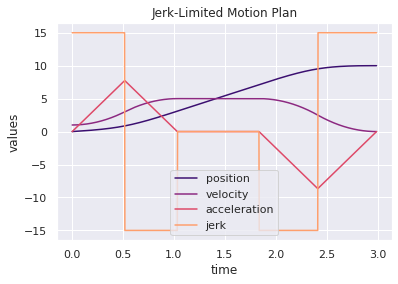

In [28]:
# visualization params
sns.set_theme(style="darkgrid")
sns.color_palette("crest", as_cmap=True)
sampling_res = 1000

# print relevant params
print(f"T_a = {T_a}, T_v = {T_v}, T_d = {T_d}, T_j1 = {T_j1}, T_j2 = {T_j2}, v_lim = {v_lim}, T = {T}")

jl_pos, jl_vel, jl_accel, jl_jerk = [], [], [], []
times = np.linspace(0, T, sampling_res)
for time in times:
    p, v, a, j = sample_trajectory(time)
    jl_pos.append(p)
    jl_vel.append(v)
    jl_accel.append(a)
    jl_jerk.append(j)

jl = pd.DataFrame({"time" : times, "position" : jl_pos, "velocity" : jl_vel, "acceleration" : jl_accel, "jerk" : jl_jerk})
jl = jl.melt('time', var_name='measurements', value_name='values')
sns.lineplot(x="time", y="values", hue='measurements', data=jl, palette="magma")
plt.title("Jerk-Limited Motion Plan")
plt.legend()
plt.show()